# Introducción a PySpark y MLlib


Este notebook contiene materiales básicos y ejemplos/ejercicios sobre el uso de pyspark para machine learning a través de MLlib de Spark (versión Spark 1.4.1). MLLib admite el uso de dataframes de Spark para construir el pipeline de machine learning.

https://spark.apache.org/docs/latest/ml-guide.html


## ¿Por qué Spark?

Spark, como plataforma de computación en clúster rápida, proporciona escalabilidad, tolerancia a fallos e integración perfecta con los pipelines de big data existentes. Spark puede escalar hasta cientos de máquinas y distribuir la computación en comparación con otras herramientas de machine learning como R, Matlab y Scipy que se ejecutan en una sola máquina.

Aquí hay una comparación de Databricks (fundada por los creadores de Spark), los tiempos de ejecución entre R vs MLLib para la correlación de Pearson en un clúster de 32 nodos

https://databricks.com/blog/2014/08/27/statistics-functionality-in-spark.html

<img src="image/Spark-vs-R-pearson.png">


## ¿Por qué PySpark?

A continuación se muestra la figura de rendimiento para Pyspark Dataframe, que parece tener un rendimiento comparable con el dataframe de Scala

<img src="image/spark-dataframes-and-ml-pipelines-11-638.jpg">


Y además Python tiene muchas bibliotecas de machine learning incluyendo scikit-learn

https://wiki.python.org/moin/PythonForArtificialIntelligence

Tiene bibliotecas de visualización como matplotlib, ggplot, seaborn etc...

# Descripción General

Para los usuarios primerizos de IPython notebook, las celdas de código a continuación se pueden ejecutar directamente desde este notebook ya sea presionando el ícono "play" en la parte superior, o presionando la tecla CTRL + Enter. La configuración del perfil para este notebook de IPython permite que la API de PySpark sea llamada directamente desde las celdas de código siguientes. Además de eso, se ha instalado la distribución Anaconda Python que incluye bibliotecas comunes como numpy, scikit-learn, scipy, pandas etc.


Este ejercicio recorrerá la construcción de un pipeline de machine learning con MLlib para propósitos de clasificación.
El ejercicio incluye:
- cargar los datos en un dataframe de Spark
- preprocesar los datos crudos
- extracción/transformación de características
- entrenamiento del modelo de clasificación
- crear pipeline de machine learning para envolver la caracterización y clasificaciones
- ajuste de hiperparámetros y validación cruzada

## Dataset - Predicción para Campaña de marketing directo bancario
Los siguientes ejercicios en PySpark se aplicarán a un problema de clasificación en un conjunto de datos obtenido del Repositorio UCI Machine Learning.
http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#
Estos datos ya han sido cargados en tu VM y están disponibles en la carpeta data/ que puedes ver desde Jupyter.
Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de clasificación es predecir si el cliente suscribirá un depósito a plazo (variable y). Esto es básicamente una clasificación binaria, donde las clases predichas son sí o no.
Algunos de los encabezados han sido renombrados para mayor claridad.
### Información de Atributos:
| Posición | Heading | Descripción | Valores |       
| :- |:-- |:------------------------------------ | :------------|
|1| age | Edad del cliente | numeric |
|2| job | Tipo de trabajo del cliente |'admin.','blue-collar','entrepreneur','housemaid', 'management','retired','self-employed','services','student','technician','unemployed','unknown'|
|3| marital | Estado civil | 'divorced','married','single','unknown'|
|4| education | Nivel educativo |'basic.4y','basic.6y','basic.9y','high.school', 'illiterate','professional.course','university.degree','unknown'|
|5| default | ¿Tiene crédito en mora? | 'no','yes','unknown'|
|6| housing | ¿Tiene préstamo de vivienda? | 'no','yes','unknown'|
|7| loan | ¿Tiene préstamo personal? | 'no','yes','unknown'|
|8| contact | Tipo de comunicación de contacto | 'cellular','telephone'|
|9| month | Último mes de contacto del año| 'jan', 'feb', 'mar', ..., 'nov', 'dec'|
|10| day_of_week |Último día de contacto de la semana|'mon','tue','wed','thu','fri'|
|11| duration |Duración del último contacto en segundos. Nota importante: este atributo afecta altamente el objetivo de salida (ej., si duration=0 entonces y='no'). Sin embargo, la duración no se conoce antes de realizar una llamada. También, después del final de la llamada y es obviamente conocido. Por lo tanto, esta entrada solo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista.| numeric |
|12| campaign |Número de contactos realizados durante esta campaña y para este cliente| numeric |
|13| pdays |Número de días transcurridos después de que el cliente fue contactado por última vez de una campaña anterior (999 significa que el cliente no fue contactado previamente)| numeric |
|14| previous |Número de contactos realizados antes de esta campaña y para este cliente| numeric |
|15| outcome_of_prev | Resultado de la campaña de marketing anterior |'failure','nonexistent','success'|
|16| emp_variation_rate | Tasa de variación del empleo - indicador trimestral | numeric |
|17|consumer_price_idx | Índice de precios al consumidor - indicador mensual | numeric |
|18|consumer_conf_idx| Índice de confianza del consumidor - indicador mensual | numeric |
|19|euribor3m| Tasa euribor a 3 meses - indicador diario | numeric |
|20|num_of_employees| Número de empleados - indicador trimestral | numeric |
|21|has_subscribed| ¿El cliente ha suscrito un depósito a plazo? Nota: Esto no es un atributo, sino la etiqueta de las observaciones | 'yes','no'|

# 1. Primero, Cargando los datos

SparkSql core soporta varios orígenes de datos como Parquet, Json, Avro etc.
Sin embargo, para CSV, requiere usar un Paquete Spark adicional. Actualmente existen las siguientes opciones: spark-csv por el equipo de Databricks, y pyspark_csv.

https://github.com/seahboonsiew/pyspark-csv

https://github.com/databricks/spark-csv

Se seleccionó pyspark_csv debido a su capacidad para inferir el esquema, en comparación con spark-csv que por defecto establece todas las columnas como tipos string. :(

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("LeerCSV") \
    .getOrCreate()

# Definir el esquema explícitamente
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("marital", StringType(), True),
    StructField("education", StringType(), True),
    StructField("default", StringType(), True),
    StructField("housing", StringType(), True),
    StructField("loan", StringType(), True),
    StructField("contact", StringType(), True),
    StructField("month", StringType(), True),
    StructField("day_of_week", StringType(), True),
    StructField("duration", IntegerType(), True),
    StructField("campaign", IntegerType(), True),
    StructField("pdays", IntegerType(), True),
    StructField("previous", IntegerType(), True),
    StructField("outcome_of_prev", StringType(), True),
    StructField("emp_variation_rate", DoubleType(), True),
    StructField("consumer_price_idx", DoubleType(), True),
    StructField("consumer_conf_idx", DoubleType(), True),
    StructField("euribor3m", DoubleType(), True),
    StructField("num_employees", DoubleType(), True),
    StructField("has_subscribed", StringType(), True)
])

# Leer el archivo CSV especificando el separador y el esquema
rawDataFrame = spark.read \
    .option("header", "true") \
    .option("delimiter", ",") \
    .option("encoding", "UTF-8") \
    .schema(schema) \
    .csv("dbfs:/FileStore/datos/bank_additional_full_data.csv")

# Verificar el esquema
print("Esquema del DataFrame:")
rawDataFrame.printSchema()

# Ver las primeras filas
print("\nPrimeras 5 filas del DataFrame:")
rawDataFrame.show(5)

# Verificar el número de columnas y filas
print("\nInformación del DataFrame:")
print(f"Número de columnas: {len(rawDataFrame.columns)}")
print(f"Número de filas: {rawDataFrame.count()}")

Esquema del DataFrame:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- outcome_of_prev: string (nullable = true)
 |-- emp_variation_rate: double (nullable = true)
 |-- consumer_price_idx: double (nullable = true)
 |-- consumer_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- num_employees: double (nullable = true)
 |-- has_subscribed: string (nullable = true)


Primeras 5 filas del DataFrame:
+---+---------+-------+-----------+-------+-------+----+---------

## 2. Preprocesamiento de Datos

Preprocesar los datos si es necesario.

Como se mencionó anteriormente, la columna "duration" no debe usarse como parte de las características ya que no se conocerá hasta que se realicen las llamadas telefónicas.
Entonces, el siguiente paso será eliminar la columna duration.

No hay valores faltantes en los conjuntos de datos. Si se requiere el reemplazo de valores faltantes, podríamos usar la función Dataframe.fillna (similar a pandas).

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction

# Número de registros
print("Número de observaciones originalmente: %s" % rawDataFrame.count())
print("Número de columnas originalmente: %s" % len(rawDataFrame.columns))

# Eliminar la columna duration ya que es solo para fines de referencia. No sabremos la duración hasta después de conocer el resultado de
# si el cliente se suscribió al depósito a plazo.
filteredDf = rawDataFrame.drop("duration")

print("Número de observaciones filtradas: %s" % filteredDf.count())
print("Número de columnas después de eliminar: %s" % len(filteredDf.columns))

# Ver un resumen de las columnas
filteredDf.describe("age").show()
filteredDf.describe("pdays").show()
filteredDf.describe("emp_variation_rate").show()

Número de observaciones originalmente: 41188
Número de columnas originalmente: 21
Número de observaciones filtradas: 41188
Número de columnas después de eliminar: 20
+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             41188|
|   mean| 40.02406040594348|
| stddev|10.421249980934045|
|    min|                17|
|    max|                98|
+-------+------------------+

+-------+-----------------+
|summary|            pdays|
+-------+-----------------+
|  count|            41188|
|   mean|962.4754540157328|
| stddev|186.9109073447412|
|    min|                0|
|    max|              999|
+-------+-----------------+

+-------+-------------------+
|summary| emp_variation_rate|
+-------+-------------------+
|  count|              41188|
|   mean|0.08188550063187984|
| stddev| 1.5709597405170321|
|    min|               -3.4|
|    max|                1.4|
+-------+-------------------+



La columna de etiqueta está actualmente en formato string. Pero los clasificadores MLlib como Regresión Logística y árboles de decisión esperan que el Dataframe contenga las siguientes estructuras para el entrenamiento:
   - "features": columna de vector único que representa los vectores de características para la observación
   - "label": tipo double, que representa la etiqueta

In [0]:
# Agregar la columna label, que básicamente corresponde a la columna has_subscribed
toDouble = UserDefinedFunction(lambda x: 1. if x == "yes" else 0., DoubleType())
filteredDf = filteredDf.withColumn("label", toDouble(filteredDf["has_subscribed"]))
filteredDf.show(3)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|outcome_of_prev|emp_variation_rate|consumer_price_idx|consumer_conf_idx|euribor3m|num_employees|has_subscribed|label|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|       1|  999|       0|    nonexistent|               1.1|            93.994|            -36.4|    4.857|       5191.0|            no|  0.0|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|       1|  9

+--------------+-----+
|has_subscribed|count|
+--------------+-----+
|            no|36548|
|           yes| 4640|
+--------------+-----+



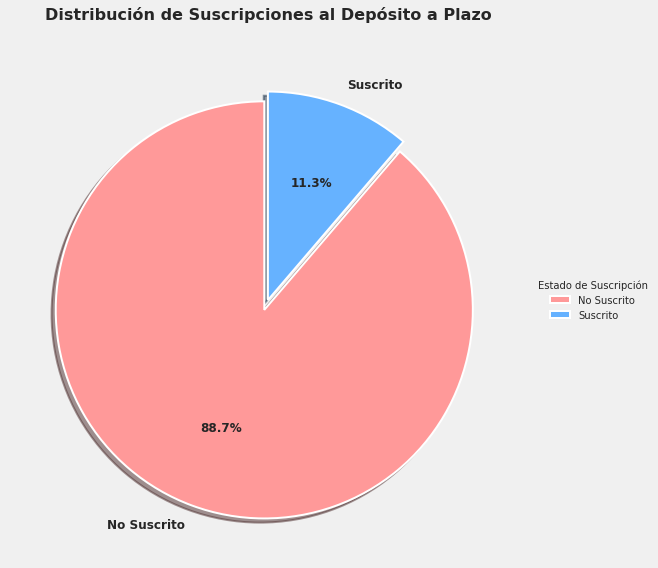


Estadísticas de Suscripción:
No Suscrito: 36,548 clientes (88.7%)
Suscrito: 4,640 clientes (11.3%)


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo
plt.style.use('seaborn')
sns.set_palette("husl")

# Mostrar número de clientes que se han suscrito al depósito a plazo vs los que no
numOfSignUps = filteredDf.groupBy("has_subscribed").count()
numOfSignUps.show()

# Convertir DataFrame a RDD y luego aplicar map
labels = numOfSignUps.rdd.map(lambda row: 'Suscrito' if row.has_subscribed == 'yes' else 'No Suscrito').collect()
sizes = numOfSignUps.rdd.map(lambda row: row['count']).collect()

# Configurar colores y estilo
colors = ['#FF9999', '#66B2FF']
explode = (0.05, 0)  # Destacar la primera porción

# Crear figura con fondo personalizado
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('#f0f0f0')

# Crear el gráfico de pie
plt.pie(sizes, 
       explode=explode,
       labels=labels,
       colors=colors,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       textprops={'fontsize': 12, 'fontweight': 'bold'},
       wedgeprops={'edgecolor': 'white', 'linewidth': 2})

# Agregar título con estilo
plt.title('Distribución de Suscripciones al Depósito a Plazo', 
         pad=20, 
         fontsize=16, 
         fontweight='bold')

# Agregar leyenda
plt.legend(labels,
         title="Estado de Suscripción",
         loc="center left",
         bbox_to_anchor=(1, 0, 0.5, 1))

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir estadísticas
total = sum(sizes)
print("\nEstadísticas de Suscripción:")
for label, size in zip(labels, sizes):
   percentage = (size/total) * 100
   print(f"{label}: {size:,} clientes ({percentage:.1f}%)")

In [0]:
# Registrar este DataFrame como una tabla
filteredDf.registerTempTable("campaign")

# Ejecutar consultas sql
queryResult = sqlContext.sql("SELECT age, job, marital FROM campaign WHERE has_subscribed = 'yes'")
queryResult.show()

/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+---+------------+--------+
|age|         job| marital|
+---+------------+--------+
| 41| blue-collar|divorced|
| 49|entrepreneur| married|
| 49|  technician| married|
| 41|  technician| married|
| 45| blue-collar| married|
| 42| blue-collar| married|
| 39|   housemaid| married|
| 28|     unknown|  single|
| 44|    services| married|
| 42|  technician| married|
| 42|  management| married|
| 39|    services| married|
| 42| blue-collar| married|
| 45|   housemaid| married|
| 31|      admin.|  single|
| 28|     student|  single|
| 41|entrepreneur| married|
| 37| blue-collar|  single|
| 44| blue-collar| married|
| 44|entrepreneur| married|
+---+------------+--------+
only showing top 20 rows



## 3. División de Conjuntos de Datos

Entrenar el modelo y probarlo en los mismos datos podría ser un problema: un modelo que simplemente repitiera las etiquetas de las observaciones que ha visto tendría una puntuación perfecta pero fallaría en predecir algo útil en datos nuevos no vistos. Esta situación se llama sobreajuste (overfitting).

Para evitar el sobreajuste, es una práctica común al entrenar un modelo de machine learning (supervisado) dividir los datos disponibles en conjuntos de entrenamiento, prueba y validación.

Crearemos 3 conjuntos de datos:
- conjunto de entrenamiento: para entrenar nuestros modelos de clasificación
- conjunto de validación: para evaluar el rendimiento de nuestros modelos entrenados (y ajustar los parámetros (hiperparámetros) de los modelos)
- conjunto de prueba: para probar los modelos (muestras no vistas, no utilizadas en el entrenamiento ni en la selección del modelo)

Nuestro objetivo es crear un modelo que pueda generalizarse bien al conjunto de datos y evitar el sobreajuste.

In [0]:
# División en conjuntos de entrenamiento(60%), validación(20%) y prueba(20%)
trainingRdd, validationRdd, testRdd = filteredDf.rdd.randomSplit([6, 2, 2], seed=0)  
trainingDf = trainingRdd.toDF() 
validationDf = validationRdd.toDF() 
testDf = testRdd.toDF() 

print(trainingDf.take(1)) 

# Vamos a cachear estos conjuntos de datos
trainingDf.cache()
validationDf.cache()
testDf.cache()

print("Número de observaciones de entrenamiento: %s" % trainingDf.count())  
print("Número de observaciones de validación: %s" % validationDf.count()) 
print("Número de observaciones de prueba: %s" % testDf.count())         

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', campaign=1, pdays=999, previous=0, outcome_of_prev='nonexistent', emp_variation_rate=1.1, consumer_price_idx=93.994, consumer_conf_idx=-36.4, euribor3m=4.857, num_employees=5191.0, has_subscribed='no', label=0.0)]
Número de observaciones de entrenamiento: 24770
Número de observaciones de validación: 8183
Número de observaciones de prueba: 8235


## 4. Transformación de Características Categóricas

Para los atributos categóricos, necesitamos convertir esas categorías basadas en texto en características numéricas antes de intentar entrenar/construir un modelo de clasificación con estos datos.

Por ejemplo, el atributo "marital" es una característica categórica con 4 valores posibles: 'divorced','married','single','unknown'.

Usaremos la técnica de caracterización incorporada de MLlib llamada codificación one hot para transformar tales características categóricas en vectores de características que consisten en 0s y 1s binarios. Consulte la documentación de MLLib para obtener más información sobre la codificación one hot
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html

VectorAssembler se utiliza para ensamblar los vectores de características.

Si las variables en los vectores de características tienen una diferencia de escala demasiado grande, es posible que desee normalizarlas con escalado de características. MLlib ofrece standardScaler como parte de pyspark.mllib. Otras técnicas de reducción de dimensionalidad disponibles incluyen PCA y SVD.

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Convertir los atributos categóricos a características binarias
categoricalAttributes = ['job', 'marital', 'education', 'default', 
                        'housing', 'loan', 'contact', 
                        'month', 'day_of_week', 'outcome_of_prev']

# Construir una lista de etapas de pipeline para el pipeline de machine learning.
# Comenzar con el transformador de características one hot encoder para construir las características categóricas
pipelineStages = []
for columnName in categoricalAttributes:
   stringIndexer = StringIndexer(inputCol=columnName, outputCol=columnName + "Index")
   pipelineStages.append(stringIndexer)
   oneHotEncoder = OneHotEncoder(inputCol=columnName + "Index", outputCol=columnName + "Vec")
   pipelineStages.append(oneHotEncoder)

print("%s transformadores string indexer y one hot encoders" % len(pipelineStages))
assert len(pipelineStages) == len(categoricalAttributes)*2

# Combinar todas las columnas de características en una sola columna en el dataframe
numericColumns = ['age', 'campaign', 'pdays', 'previous',
          'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 
                 'euribor3m', 'num_employees']
categoricalCols = [s + "Vec" for s in categoricalAttributes]
allFeatureCols = numericColumns + categoricalCols
vectorAssembler = VectorAssembler(
   inputCols=allFeatureCols,
   outputCol="features")
pipelineStages.append(vectorAssembler)
print("%s columnas de características: %s" % (len(allFeatureCols), allFeatureCols))

# Construir pipeline para extracción de características
featurePipeline = Pipeline(stages=pipelineStages)
featureOnlyModel = featurePipeline.fit(trainingDf)

20 transformadores string indexer y one hot encoders
19 columnas de características: ['age', 'campaign', 'pdays', 'previous', 'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 'euribor3m', 'num_employees', 'jobVec', 'maritalVec', 'educationVec', 'defaultVec', 'housingVec', 'loanVec', 'contactVec', 'monthVec', 'day_of_weekVec', 'outcome_of_prevVec']


In [0]:
# Crear lista de Dataframes con características
trainingFeaturesDf = featureOnlyModel.transform(trainingDf)
validationFeaturesDf = featureOnlyModel.transform(validationDf)
testFeaturesDf = featureOnlyModel.transform(testDf)

# Echar un vistazo
trainingFeaturesDf.select("features", "label").rdd.take(2)

Out[76]: [Row(features=SparseVector(52, {0: 56.0, 1: 1.0, 2: 999.0, 4: 1.1, 5: 93.994, 6: -36.4, 7: 4.857, 8: 5191.0, 17: 1.0, 20: 1.0, 27: 1.0, 30: 1.0, 33: 1.0, 34: 1.0, 37: 1.0, 47: 1.0, 50: 1.0}), label=0.0),
 Row(features=SparseVector(52, {0: 57.0, 1: 1.0, 2: 999.0, 4: 1.1, 5: 93.994, 6: -36.4, 7: 4.857, 8: 5191.0, 12: 1.0, 20: 1.0, 24: 1.0, 31: 1.0, 33: 1.0, 34: 1.0, 37: 1.0, 47: 1.0, 50: 1.0}), label=0.0)]

## 5. Clasificación No Supervisada - Agrupamiento con Mezcla Gaussiana

MLLib ofrece algunos métodos de agrupamiento. Esto podría ser útil cuando se trabaja con datos no etiquetados, donde es imposible aplicar algoritmos de aprendizaje supervisado.

La lista de técnicas de agrupamiento disponibles actualmente en Spark incluye:
- K-means
- Mezcla Gaussiana
- Agrupamiento por iteración de potencia (PIC)
- Asignación latente de Dirichlet (LDA)
- K-means en streaming

Vamos a entrenar un modelo de mezcla Gaussiana y ver cómo funciona con nuestro conjunto de características actual

In [0]:
from pyspark.mllib.clustering import KMeans, KMeansModel, GaussianMixture
from pyspark.mllib.linalg import Vectors
from numpy import array
from math import sqrt

# Extraer las "características" del conjunto de entrenamiento en formato vector
def extractVectorFeatures(featuresDf):
    # Convertir el vector de características a formato requerido por mllib
    return featuresDf.select("features").rdd.map(lambda row: Vectors.dense(row.features.toArray()))

# Función para calcular la precisión
def calculateAccuracy(labelsAndPredictionsRdd):
    """
    Calcula la precisión para un RDD dado de etiquetas y predicciones
    entrada:  
        labelsAndPredictionsRdd : RDD que consiste en tuplas (etiqueta, predicción)
    
    retorna: precisión en porcentaje como float
    """
    return (labelsAndPredictionsRdd.filter(lambda x: x[0] == x[1]).count() 
            / float(labelsAndPredictionsRdd.count())* 100)

# Construir el modelo (agrupar los datos)
trainingRdd = extractVectorFeatures(trainingFeaturesDf)

# Verificar que los datos están en el formato correcto
print("Ejemplo de datos de entrenamiento:")
print(trainingRdd.first())

numOfClusters = 2
# Agregar parámetros adicionales para más control
gmm = GaussianMixture.train(trainingRdd, 
                           k=numOfClusters,
                           convergenceTol=0.01,
                           maxIterations=100,
                           seed=1)

def getGmmPredictedAccuracy(featuresDf, featuresRdd, model):
    # Ejecutar la predicción en el featuresRdd
    predictionList = model.predict(featuresRdd).collect()
    actualAndPred = (featuresDf.select("label").rdd
            .map(lambda row: float(row.label))  # Asegurar que las etiquetas sean float
            .zipWithIndex()
            .map(lambda x: (x[0], float(predictionList[x[1]]))))  # Asegurar que las predicciones sean float
    # Mapear el dataframe de características de entrenamiento a la lista de etiquetas predichas por índice
    return calculateAccuracy(actualAndPred)

# Predecir conjunto de entrenamiento con modelo de clusters GMM
trainGmmAccuracy = getGmmPredictedAccuracy(trainingFeaturesDf, trainingRdd, gmm)

# Repetir con conjunto de prueba
testRdd = extractVectorFeatures(testFeaturesDf)
testGmmAccuracy = getGmmPredictedAccuracy(testFeaturesDf, testRdd, gmm)

# Repetir con conjunto de validación
validationRdd = extractVectorFeatures(validationFeaturesDf)
validationGmmAccuracy = getGmmPredictedAccuracy(validationFeaturesDf, validationRdd, gmm)

print("==========================================")
print("Precisión GMM contra conjunto de entrenamiento sin filtrar(%) = " + str(trainGmmAccuracy))
print("Precisión GMM contra conjunto de prueba(%) = " + str(testGmmAccuracy))
print("Precisión GMM contra conjunto de validación(%) = " + str(validationGmmAccuracy))
print("==========================================")

Ejemplo de datos de entrenamiento:
[56.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0]
Precisión GMM contra conjunto de entrenamiento sin filtrar(%) = 79.39039160274525
Precisión GMM contra conjunto de prueba(%) = 79.19854280510017
Precisión GMM contra conjunto de validación(%) = 79.64071856287424


## 6. Aprendizaje Supervisado

En los pasos anteriores, hemos encadenado una lista de codificadores de características para codificar nuestras características categóricas.
A continuación, procederemos a usar la API Pipeline de MLlib para construir el pipeline de ML. La ventaja de la API Pipeline es que agrupa y encadena los transformadores (codificadores de características, selectores de características, etc.) y estimadores (modelo entrenado) juntos y facilita la reutilización.

https://spark.apache.org/docs/latest/ml-guide.html#migration-guide

Documentación de la API PySpark sobre clasificación:
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/classification.html

Crearemos un modelo de regresión logística donde el modelo hace predicciones aplicando la función logística. Los hiperparámetros para un modelo de regresión logística incluyen:
- parámetro de regularización (regParam) para prevenir el sobreajuste penalizando modelos con valores de parámetros extremos


In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Configurar pipeline de machine learning con
# un estimador (clasificación) (Regresión Logística)
lr = LogisticRegression(maxIter=10, regParam=0.01)
lrPipeline = Pipeline(stages=[lr])

# Ajustar el pipeline para crear un modelo con los datos de entrenamiento
lrPipelineModel = lrPipeline.fit(trainingFeaturesDf)

def getAccuracyForPipelineModel(featuresDf, model):
    # Realizar predicción usando featuresdf y pipelineModel
    # Calcular la precisión en porcentaje float
    results = model.transform(featuresDf)
    # Convertir DataFrame a RDD para usar map
    labelsAndPreds = results.select("label", "prediction").rdd.map(lambda row: (row.label, row.prediction))
    return (calculateAccuracy(labelsAndPreds), results) 

# Evaluar el modelo en datos de entrenamiento
lrTrainAccuracy, lrTrainResultDf = getAccuracyForPipelineModel(trainingFeaturesDf, lrPipelineModel)

# Repetir en datos de prueba
lrTestAccuracy, lrTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, lrPipelineModel)

# Repetir en datos de validación
lrValidationAccuracy, lrValidationResultDf = getAccuracyForPipelineModel(validationFeaturesDf, lrPipelineModel)

print("==========================================")
print("Precisión del Modelo de Regresión Logística en entrenamiento (%) = " + str(lrTrainAccuracy))
print("Precisión del Modelo de Regresión Logística en prueba (%) = " + str(lrTestAccuracy))
print("Precisión del Modelo de Regresión Logística en validación (%) = " + str(lrValidationAccuracy))
print("==========================================")

Precisión del Modelo de Regresión Logística en entrenamiento (%) = 90.05248284214777
Precisión del Modelo de Regresión Logística en prueba (%) = 89.77534911961142
Precisión del Modelo de Regresión Logística en validación (%) = 90.04032750824881


In [0]:
#you can create a pipeline combining multiple pipelines 
#(e.g feature extraction pipeline, and classification pipeline)
combinedPipeline = Pipeline(stages= [featurePipeline, lrPipeline])

In [0]:
# Run the prediction with our trained model on test data (which has not been used in training)
# Make predictions on test observations and print results.
selected = lrTestResultDf.select("has_subscribed", "label", "prediction")

#Show number of predicted results
predictedLabel = selected.groupBy("prediction").count()
predictedLabel.show()

selected.show(20)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7933|
|       1.0|  302|
+----------+-----+

+--------------+-----+----------+
|has_subscribed|label|prediction|
+--------------+-----+----------+
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
+--------------+-----+----------+
only showing top 20 rows



## Ajuste de Hiperparámetros con GridSearch

Una de las tareas importantes en machine learning es usar los datos para encontrar los parámetros óptimos para que nuestro modelo realice la clasificación.

En la siguiente sección, intentaremos entrenar el modelo de Regresión Logística con diferentes valores para el parámetro de regularización (regParam) y número de iteraciones máximas. La precisión del modelo se valida con el conjunto de datos de validación que creamos anteriormente.

Los mejores parámetros se seleccionan basándose en esto.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
from math import log

maxIterRange = [5, 10, 30, 50, 100]
regParamRange = [1e-10, 1e-5, 1e-1]
#baseline values from previous section
bestIter = 10
bestRegParam = 0.01
bestModel = lr
bestAccuracy = lrValidationAccuracy

#for plotting purpose
iterations = []
regParams = []
accuracies = []
for maxIter in maxIterRange:
    for rp in regParamRange:
        currentLr = LogisticRegression(maxIter=maxIter, regParam=rp)
        pipeline = Pipeline(stages=[currentLr])
        model = pipeline.fit(trainingFeaturesDf)
        
        #use validation dataset test for accuracy
        accuracy, resultDf = getAccuracyForPipelineModel(validationFeaturesDf, model)
        print("maxIter: %s, regParam: %s, accuracy: %s " % (maxIter, rp, accuracy))
        accuracies.append(accuracy)
        regParams.append(log(rp))
        iterations.append(maxIter)
        
        if accuracy > lrValidationAccuracy:
            bestIter = maxIter
            bestRegParam = rp
            bestModel = model
            bestAccuracy = accuracy


print("Best parameters: maxIter %s, regParam %s, accuracy : %s" % (bestIter, bestRegParam, bestAccuracy))

# Repeat on test data
gridTestAccuracy, gridTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, bestModel)

print("==========================================")
print("Grid search Model test accuracy (%) = " + str(gridTestAccuracy))
print("==========================================")


maxIter: 5, regParam: 1e-10, accuracy: 90.00366613711353 
maxIter: 5, regParam: 1e-05, accuracy: 90.00366613711353 
maxIter: 5, regParam: 0.1, accuracy: 89.80813882439203 
maxIter: 10, regParam: 1e-10, accuracy: 90.06476842233899 
maxIter: 10, regParam: 1e-05, accuracy: 90.06476842233899 
maxIter: 10, regParam: 0.1, accuracy: 89.90590248075277 
maxIter: 30, regParam: 1e-10, accuracy: 90.2602957350605 
maxIter: 30, regParam: 1e-05, accuracy: 90.2358548209703 
maxIter: 30, regParam: 0.1, accuracy: 89.90590248075277 
maxIter: 50, regParam: 1e-10, accuracy: 90.18697299278993 
maxIter: 50, regParam: 1e-05, accuracy: 90.18697299278993 
maxIter: 50, regParam: 0.1, accuracy: 89.90590248075277 
maxIter: 100, regParam: 1e-10, accuracy: 90.24807527801539 
maxIter: 100, regParam: 1e-05, accuracy: 90.2358548209703 
maxIter: 100, regParam: 0.1, accuracy: 89.90590248075277 
Best parameters: maxIter 100, regParam 1e-05, accuracy : 90.2358548209703
Grid search Model test accuracy (%) = 89.7996357012750

<command-281350475369410>:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(scatter)


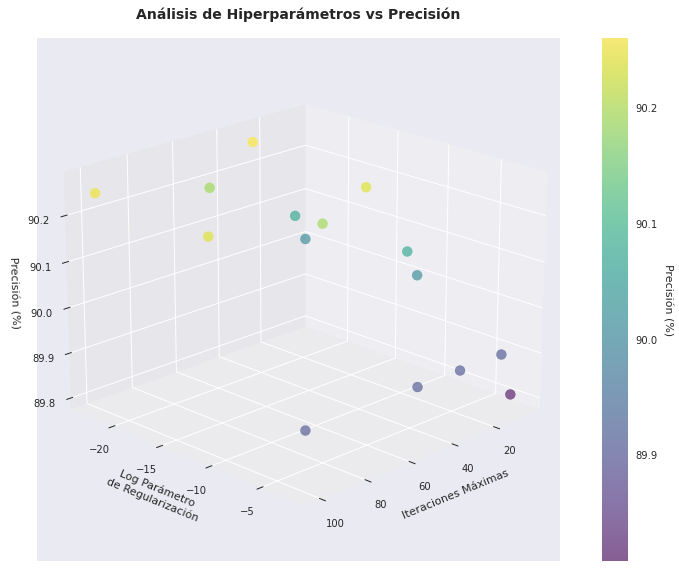

In [0]:
# Visualizar los resultados
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Configurar el estilo del gráfico
plt.style.use('seaborn')  # Usar estilo seaborn para mejor apariencia

# Crear figura y ejes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear scatter plot con más personalización
scatter = ax.scatter(iterations, regParams, accuracies,
                   s=100,  # Tamaño de los puntos
                   c=accuracies,  # Color basado en precisión
                   cmap='viridis',  # Mapa de colores
                   marker='o',  # Tipo de marcador
                   alpha=0.6)  # Transparencia

# Agregar barra de color
colorbar = plt.colorbar(scatter)
colorbar.set_label('Precisión (%)', rotation=270, labelpad=15)

# Personalizar ejes
ax.set_xlabel('Iteraciones Máximas', labelpad=10)
ax.set_ylabel('Log Parámetro\nde Regularización', labelpad=10)
ax.set_zlabel('Precisión (%)', labelpad=10)

# Agregar título
plt.title('Análisis de Hiperparámetros vs Precisión', 
         pad=20, 
         size=14, 
         weight='bold')

# Rotar la vista para mejor visualización
ax.view_init(elev=20, azim=45)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Validación Cruzada

Spark también soporta el ajuste de modelos mediante validación cruzada.

En una validación cruzada típica (k-fold), el conjunto de entrenamiento se divide en k conjuntos. Se sigue el siguiente procedimiento para cada uno de los k "pliegues":
- Se entrena un modelo usando k-1 de los pliegues como datos de entrenamiento
- El modelo resultante se valida en la parte restante de los datos (es decir, se usa como conjunto de prueba para calcular una medida de rendimiento como la precisión)
- La medida de rendimiento reportada por la validación cruzada k-fold es entonces el promedio de los valores calculados

En este ejercicio usaremos la clase CrossValidator proporcionada por Spark dentro del paquete pyspark.ml.tuning:

https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator

La validación cruzada es computacionalmente costosa, por lo tanto, la selección del modelo a continuación podría tomar un par de minutos...

In [0]:

# We use a ParamGridBuilder to construct a grid of parameters to search over.
grid = (ParamGridBuilder()
        .addGrid(lr.maxIter, maxIterRange) 
        .addGrid(lr.regParam,regParamRange )
        .build())


evaluator = BinaryClassificationEvaluator()

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossValidator = CrossValidator(estimator=lrPipeline, 
                                estimatorParamMaps=grid, 
                                numFolds=5,
                                evaluator=evaluator)


# Run cross-validation, and choose the best model
bestCvModel = crossValidator.fit(trainingFeaturesDf)

# verify results on training dataset
cvTrainAccuracy, cvTrainResultDf = getAccuracyForPipelineModel(trainingFeaturesDf, bestCvModel)

# Repeat on test data
cvTestAccuracy, cvTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, bestCvModel)

print("==========================================")
print("CV Model training accuracy (%) = " + str(cvTrainAccuracy))
print("CV Model test accuracy (%) = " + str(cvTestAccuracy))
print("==========================================")


CV Model training accuracy (%) = 90.05651998385143
CV Model test accuracy (%) = 89.82392228293867
